In [1]:
# %%
# Import the required modules
import os
import numpy as np
# from numpy.core.fromnumeric import mean
import pandas as pd
# import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter as df
from matplotlib.dates import DayLocator as dl
# from sklearn.linear_model import LinearRegression
# netcdf4 needs to be installed in your environment for this to work
import xarray as xr
# import json
# import urllib.request as req
# import urllib

In [2]:
# %%
# NCEP NetCDF data
# Download precipitation data for region of Verde Watershed
# Data ranges are 34.4-35.9N, 113.2-111.1W, 1989-2020

data_path = os.path.join('NCEP_Precip.nc')

# Read in the dataset as an x-array and view it
dataset = xr.open_dataset(data_path)

# 2 lat values, 2 lon values, 11688 time values
dataset['prate']['lat'].size
dataset['prate']['lon'].size
dataset['prate']['time'].size

# Extract data for a single point
# Try to get point as close to streamflow gauge as possible
# Stream gauge:  34.44833333 W, -111.7891667 E (~248.21 E)
# Convert single-point data to a Pandas Dataframe
# Convert datetime to years, days, months to make
# extracting subsets easier
lat = dataset["prate"]["lat"].values[0]
lon = dataset["prate"]["lon"].values[0]
print("Lon, Lat values:", lon, lat)
one_point = dataset["prate"].sel(lat=lat, lon=lon)
precip_df = one_point.to_dataframe()
precip_df['year'] = pd.DatetimeIndex(precip_df.index).year
precip_df['month'] = pd.DatetimeIndex(precip_df.index).month
precip_df['day'] = pd.DatetimeIndex(precip_df.index).day
precip_df

Lon, Lat values: 247.5 35.2375


,lat,lon,prate,year,month,day
time,,,,,,
1989-01-01,35.237499,247.5,0.000002,1989,1,1
1989-01-02,35.237499,247.5,0.000005,1989,1,2
1989-01-03,35.237499,247.5,0.000009,1989,1,3
1989-01-04,35.237499,247.5,0.000205,1989,1,4
1989-01-05,35.237499,247.5,0.000067,1989,1,5
...,...,...,...,...,...,...
2020-12-27,35.237499,247.5,0.000000,2020,12,27
2020-12-28,35.237499,247.5,0.000017,2020,12,28
2020-12-29,35.237499,247.5,0.000013,2020,12,29


/opt/ohpc/pub/apps/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


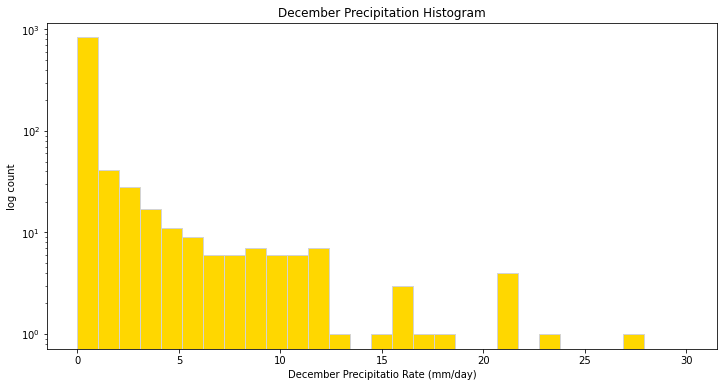

In [3]:
# %%
# Get Precip data for just the month of November,
# find the daily mean for each day of the month
# Create a histogram of that monthly climatology
# Units are in kg/m^2/s, can convert to mm by multiplying by
# the number of seconds in a day (86,400), as 1 kg/m^2 = 1 mm

dec_precip = precip_df[precip_df['month'] == 12]
dec_precip['prate'] = dec_precip['prate']*86400
my_bins = np.linspace(0, 30, num=30)
fig, ax = plt.subplots(figsize=(12, 6))
plot_title = 'December Precipitation Histogram'
ax.hist(dec_precip['prate'], bins=my_bins,
        edgecolor='lightgrey', color='gold')
ax.set(xlabel='December Precipitatio Rate (mm/day)',
       ylabel='log count', yscale='log', title=plot_title)
plt.show()
# fig.savefig('Precipitation_histogram.png')

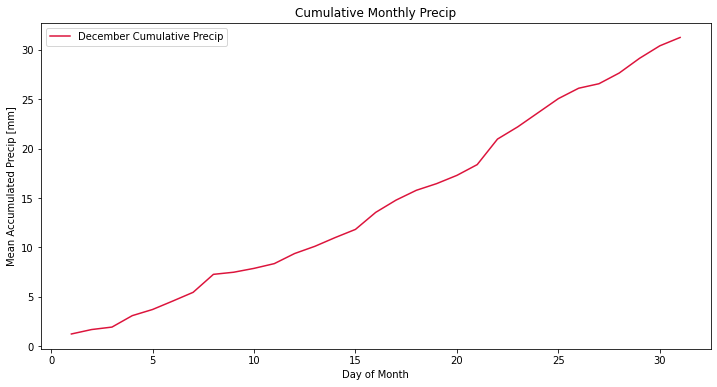

In [4]:
# %%
# Also create plot of November precipitation climatology
dec_pmean = dec_precip.groupby('day')['prate'].mean()
dec_psum = dec_pmean.cumsum()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dec_psum.index, dec_psum.values, color='crimson',
        label='December Cumulative Precip')
ax.set(title="Cumulative Monthly Precip", xlabel="Day of Month",
       ylabel="Mean Accumulated Precip [mm]")
ax.legend()
plt.show()
# fig.savefig('Monthly_precip_mean.png')

In [5]:
# %%
# From histogram, it is apparent that the vast majority of the
# days have zero or near-zero precip, can use this information
# find a climatological precipitation probability for the forecast zone
# Measurable precipitation >= 0.01 in, equal to 0.254 mm
# Shape of November Precip Dataframe is 960x6, prate is column 2
j = 0
for i in range(960):
    iprecip = dec_precip.iloc[i, [2]]
    iprecip = iprecip[0]
    if iprecip >= 0.254:
        j = j+1
precip_prob = round(j/960, 2)
print(precip_prob)

0.26


In [6]:
# %%
# Import streamflow data here
# Set the file name and path to where you have stored the data
filename = 'streamflow_week15.txt'
filepath = os.path.join('/home/u9/cahoopes/HASTools', filename)
flow_data = pd.read_table(filepath, sep='\t', skiprows=30,
                          names=['agency_cd', 'site_no', 'datetime', 'flow',
                                 'code'], parse_dates=['datetime'])
flow_data = flow_data.set_index('datetime')
flow_data['year'] = pd.DatetimeIndex(flow_data.index).year
flow_data['month'] = pd.DatetimeIndex(flow_data.index).month
flow_data['day'] = pd.DatetimeIndex(flow_data.index).day

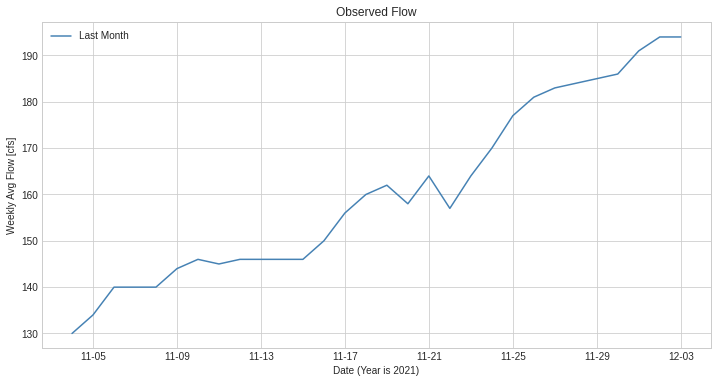

In [8]:
# %%
# Make a timeseries plot of the recent streamflow
# Time series of flow values with the x axis range limited
recent_flow = flow_data.tail(30)
xformat = df("%m-%d")
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(recent_flow['flow'], color='steelblue', label='Last Month')
ax.xaxis.set_major_formatter(xformat)
ax.xaxis.set_major_locator(dl(interval=4))
ax.set(title="Observed Flow", xlabel="Date (Year is 2021)",
       ylabel="Weekly Avg Flow [cfs]")
ax.legend()
plt.show()
# fig.savefig('Recent_flow_week15.png')

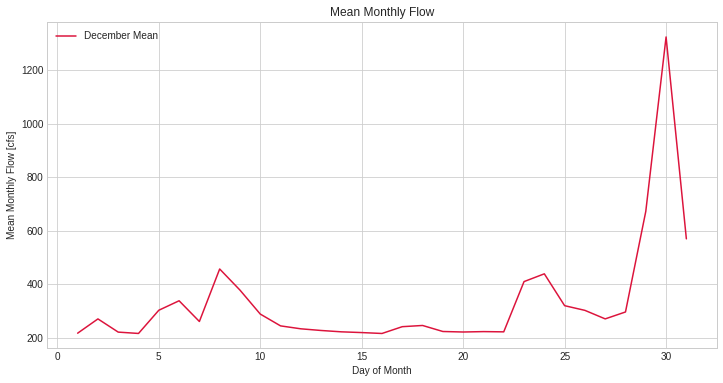

In [9]:
# %%
# Figure out how the flow behaves in forecast month(s)
# - find the mean flow for each day of the month
dec_data = flow_data[flow_data['month'] == 12]
dec_mean = dec_data.groupby('day')['flow'].mean()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dec_mean.index, dec_mean.values, color='crimson',
        label='December Mean')
ax.set(title="Mean Monthly Flow", xlabel="Day of Month",
       ylabel="Mean Monthly Flow [cfs]")
ax.legend()
plt.show()
# fig.savefig('Monthly_mean.png')

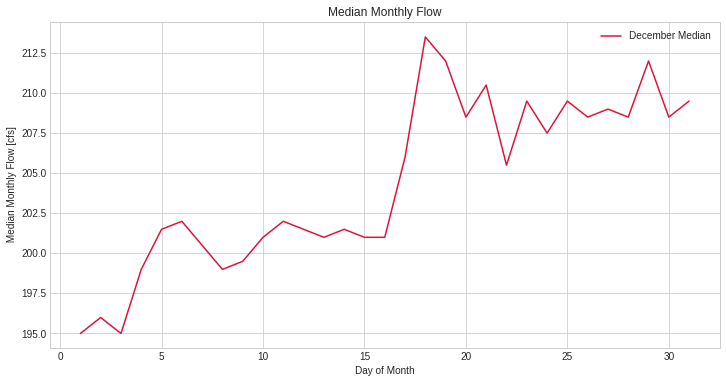

In [10]:
# %%
# Also consider median flow
dec_median = dec_data.groupby('day')['flow'].median()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dec_median.index, dec_median.values, color='crimson',
        label='December Median')
ax.set(title="Median Monthly Flow", xlabel="Day of Month",
       ylabel=" Median Monthly Flow [cfs]")
ax.legend()
plt.show()
# fig.savefig('Monthly_median.png')

In [11]:
# %%
# Create and run a function which forecasts the streamflow for the next two
# weeks based on current flow and monthly climatology (mean and median flows)
#
# For week 1, also include whether significant precip is expected, set based
# on number of days where chance of precipitation is >=50% (NWS forecast)

# Link: https://forecast.weather.gov/MapClick.php?lon=-111.85758589999749&lat=34.56146253137916#.YV4DsCVlDYs

# Cumulative, so 2 days with 30% chance equal one day of 50% chance

# Day, night probabilities separate,
# use whichever value is higher to represent the day

# Example: for 3 30% days, set precip index to 1
# A 4th day would increase the index to 2

# New for week 9 - add climatological component - based on 13% chance of precip
# per day in month of November, 13%*7=91%, 1 day of precip expected per week

# Do not include for week 2, too far out to reliably predict significant events

# Instead, forecast only based on equal weight climatology,
# using week 1 forecast as the observed value

# Equal weight means mean and median combined are equal to last observation


def flowcast(obs, mean, med, a, b, day):
    """ A fuction to interpolate streamflow using observations and climatology.

    This function takes the last streamflow observation and interpolates
    streamflow for the next two weeks using the climatological
    mean and median flow to weight the interpolation.  For the first week,
    additional weighting comes from precipitation,
    while the week 2 forecast uses the week 1 forecast as its initial value.

    Inputs: obs (float) - last streamflow observation in the initial
    PANDAS Dataframe, extracted from dataframe as a float value
    mean (pandas series) - mean flow for the month of the forecast (October)
    med (pandas series) - median flow for the month of the forecast (October)
    If forecast period includes multiple months add second mean, med input
    a (int) - number of days where precipitation is expected,
    set based on combined NWS daily precipitation probabilities divided by 50
    b (int) - number of days when precipitation is expected based on local
    climatology at 3 locations, base probability per day calculated earlier
    day (int) - day of the month of Sunday before the forecast period's start

    Outputs: 2 forecast values (f1 and f2),
    f1 for the first week, and f2 for the second week"""

    week1 = np.zeros(7)
    week2 = np.zeros(7)
    for i in range(7):
        week1[i] = mean.values[day+i]*0.25+med.values[day+i]*0.25+obs*0.5
    f1 = round(np.mean(week1)*(1+(a-b)/10))
    for j in range(7):
        week2[j] = mean.values[day+j+7]*0.25+med.values[day+j]*0.25+f1*0.5
    f2 = round(np.mean(week2))
    return(f1, f2)


# Define the necessary variables and call the function

# Manually set precipitation index using link, explanation above

# Set date based on day of month of day before first day
# in week 1 forecast period
# Climatological index for December of 2 days per week
# 3 days of precipitation expected this week
# Day should be set to 5 for week 15.

last_flow = recent_flow["flow"].iloc[-1]
precip = 3
climo = 2
date = 5
flowcast1, flowcast2 = flowcast(last_flow, dec_mean, dec_median, precip,
                                climo, date)
print('Week 1 forecast:', flowcast1, 'cfs')
print('Week 2 forecast:', flowcast2, 'cfs')

Week 1 forecast: 248 cfs
Week 2 forecast: 231 cfs
